<a href="https://colab.research.google.com/github/SwastikGorai/Playground-Series/blob/main/Season_3/Playground_Series_Season_3%2C_Episode_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install kaggle optuna -q

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import optuna
import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c playground-series-s3e16

  0% 0.00/2.65M [00:00<?, ?B/s]
100% 2.65M/2.65M [00:00<00:00, 188MB/s]


In [5]:
!unzip playground-series-s3e16.zip

Archive:  playground-series-s3e16.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [45]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [7]:
target_col = 'Age'
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()

In [8]:
def initial_check(df, title):
  print(title)
  print('------Head------ \n', df.head())
  print('------Describe--------- \n' ,df.describe())
  print('-------Unqiue--------- \n' , df.nunique())
  print('---------isna sum---------- \n' , df.isna().sum())


In [9]:
initial_check(train, 'Train')

Train
------Head------ 
    id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  
------Describe--------- 
                  id        Length      Diameter        Height        Weight  \
count  74051.000000  74051.000000  74051.000000  74051.000000  74051.000000   
mean   37025.000000      1.317460      1.024496      0.348089     23.385217   
std    21376.826729      0.287757      0.237396      0.092034     12.648153   
mi

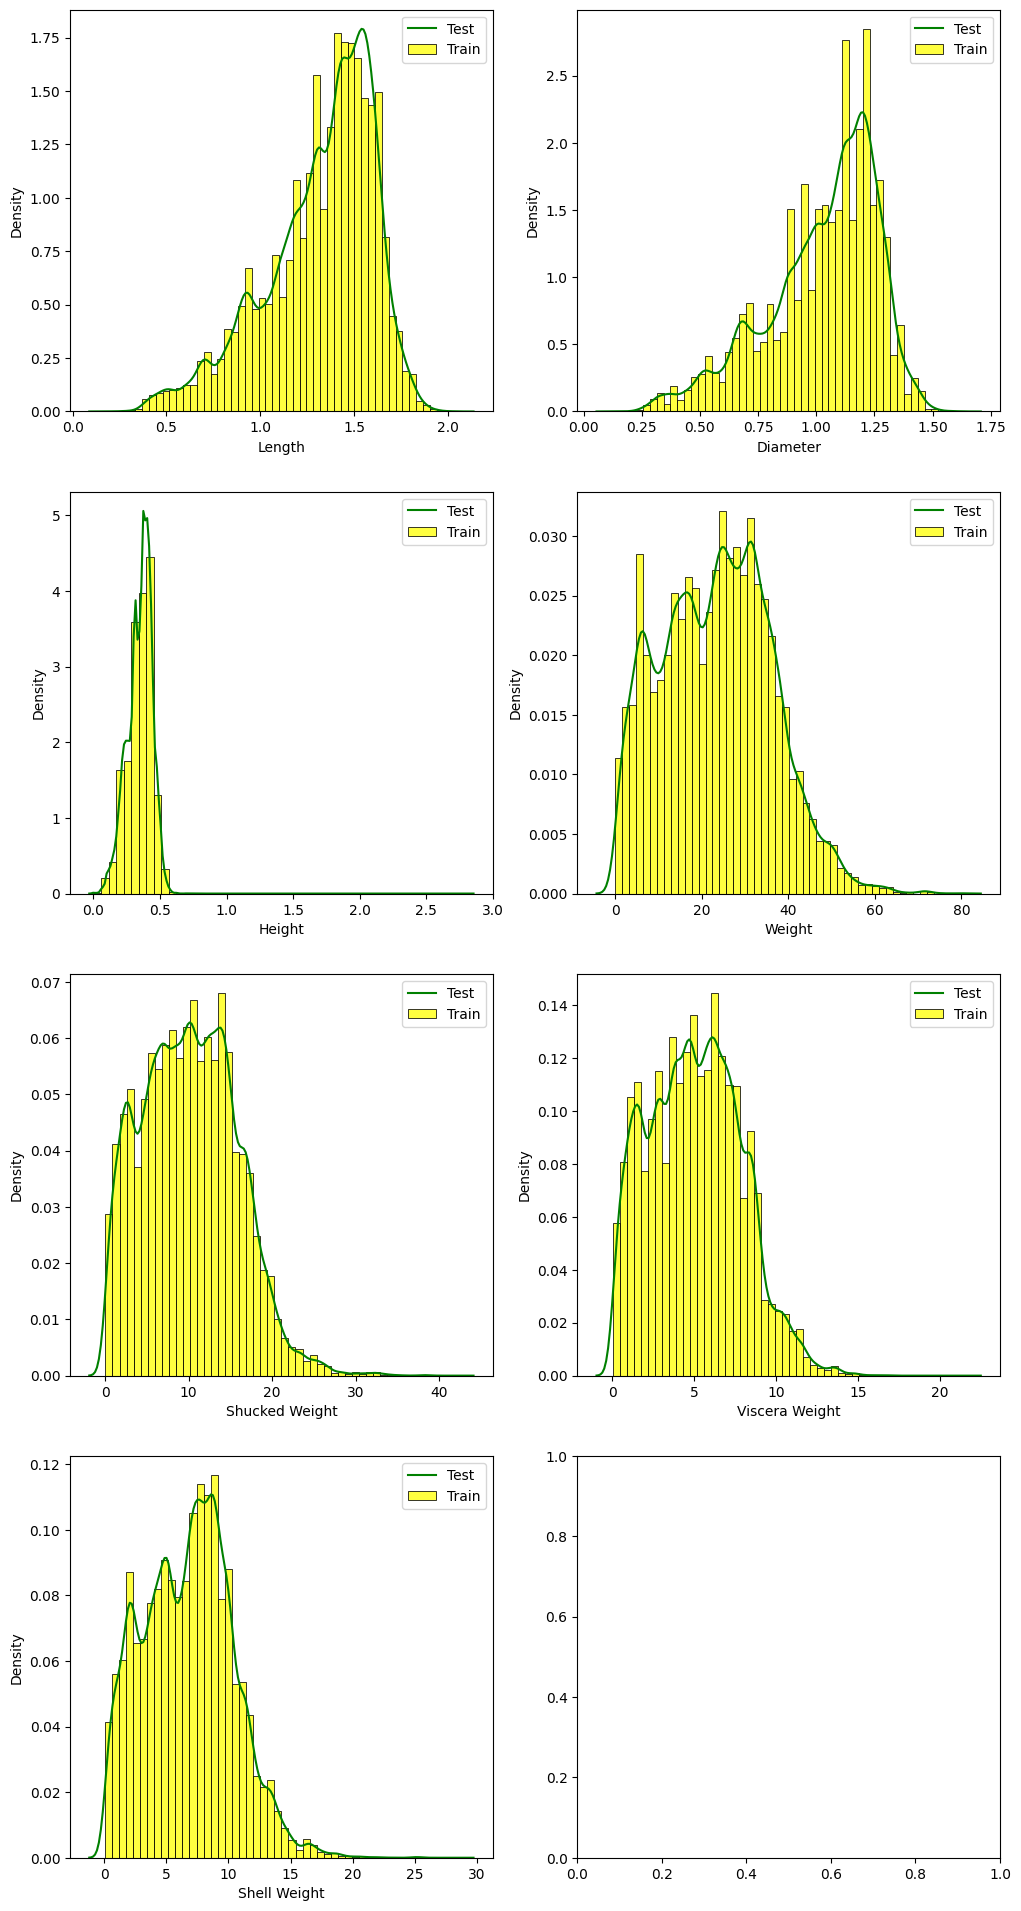

In [10]:
def histogram(train):
  fig, axes = plt.subplots(nrows= 4, ncols=2, figsize=(12,24))
  axes = axes.flatten()
  for i, col_name in enumerate(train.columns.tolist()):
    ax = axes[i]
    sns.histplot(train[col_name], kde = False, ax = ax, label = 'Train', bins = 50, stat = 'density', color = 'yellow')
    if col_name!='Age':
      sns.kdeplot(test[col_name], ax = ax, label = 'Test', color = 'green')
    ax.legend()
  plt.show()
histogram(train[num_cols])

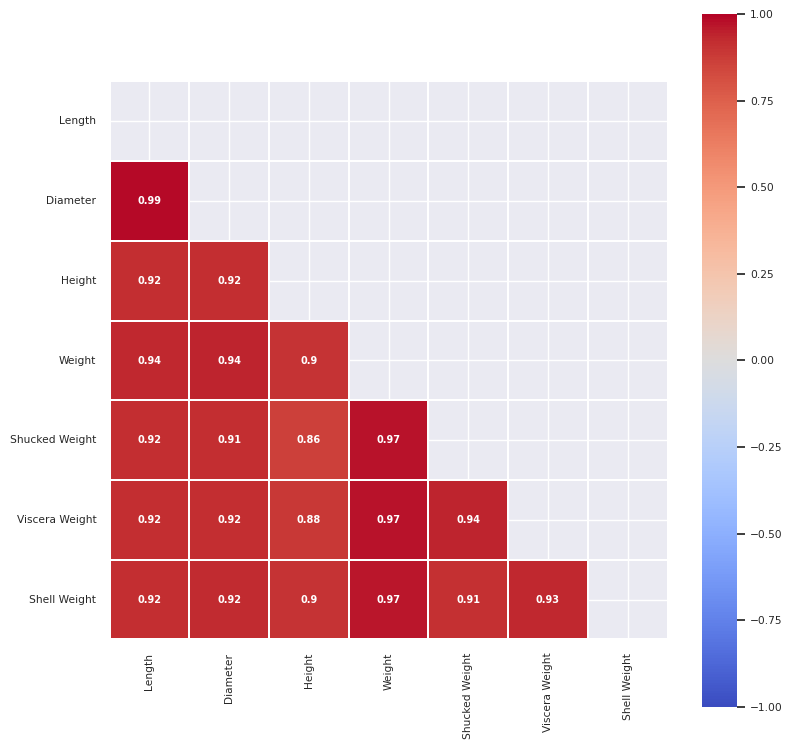

In [11]:
def heatmap(df):
  mask = np.zeros_like(df.astype(float).corr())
  mask[np.triu_indices_from(mask)] = True
  plt.figure(figsize=(9, 9))
  sns.set(font_scale=0.7)
  sns.heatmap(df.astype(float).corr(), linewidths=0.15, vmax=1.0, vmin=-1.0, 
                square=True, cmap='coolwarm', linecolor='white', annot=True, annot_kws={"size": 7, "weight": "bold"},
                mask=mask)

heatmap(train[num_cols])

In [47]:
def preprocess(train, test):
  y = train['Age']
  test.drop(['id'], axis = 1)
  train['Sex']=train['Sex'].apply(lambda row: 2 if row == "I" else (1 if row == "F" else 0))
  test['Sex']=test['Sex'].apply(lambda row: 2 if row == "I" else (1 if row == "F" else 0))
  X = train.copy().drop(['id', 'Age'], axis = 1)
  return X, y, test, train
X, y, test, train = preprocess(train, test)

In [32]:
def objective(trial):
  df = X
  target = 'Age'
  train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
  dtrain = lgb.Dataset(train_x, label=train_y)

  param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate":[ 0.005, ],
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }
  gbm = lgb.train(param, dtrain)
  preds = gbm.predict(valid_x)
  pred_labels = np.rint(preds)
  accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
  return accuracy


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [53]:
lgb_model = lgb.LGBMRegressor(
    lambda_l1= 0.000866489105840565,
    lambda_l2= 0.44852187587900977,
    num_leaves= 52,
    feature_fraction= 0.8342951070795813,
    bagging_fraction= 0.45214148776756574,
    bagging_freq= 2,
    min_child_samples= 59
)
lgb_model.fit(X,y)
testY= lgb_model.predict(test.drop(['id'], axis = 1))
predictions = pd.DataFrame(test["id"].copy())
predictions["Age"] = testY[:]
predictions.Age = predictions.Age.apply(lambda x: round(x))
predictions.to_csv("submission.csv", index= False)


[LightGBM] [Warning] lambda_l1 is set=0.000866489105840565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000866489105840565
[LightGBM] [Warning] feature_fraction is set=0.8342951070795813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342951070795813
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.44852187587900977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44852187587900977
[LightGBM] [Warning] bagging_fraction is set=0.45214148776756574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45214148776756574


In [54]:
!kaggle competitions submit -c playground-series-s3e16 -f submission.csv -m "submission 1"

100% 438k/438k [00:02<00:00, 188kB/s]
Successfully submitted to Regression with a Crab Age Dataset